## Sea Navigation

In [1]:
import pandas as pd
import math
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import numpy
import random
import copy
import matplotlib.pyplot as plt

C:\Users\borges\AppData\Local\Temp\ipykernel_15392\497218920.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data_points = pd.read_csv('../sea_navigation.csv')
data_points.head()

,x,y
0,10,0
1,20,10
2,20,20
3,40,30
4,40,80


In [3]:
data_points_list = data_points.values.tolist()
data_points_list

[[10, 0],
 [20, 10],
 [20, 20],
 [40, 30],
 [40, 80],
 [90, 50],
 [80, 40],
 [30, 80],
 [80, 60],
 [50, 80],
 [80, 100],
 [70, 20],
 [30, 50],
 [50, 60],
 [80, 50],
 [100, 50]]

In [4]:
len(data_points)

16

In [13]:
island_points = pd.read_csv('../island.csv')
island_points.head(10)

,island_x_bottom_right,island_y_bottom_right,island_x_bottom_left,island_y_bottom_left,island_x_top_left,island_y_top_left,island_x_top_right,island_y_top_right
0,38,34,35,42,39,70,44,58


### Objective Functions

In [9]:
def calculate_distance(origin_city, destiny_city):
  X1 = origin_city[0]
  Y1 = origin_city[1]
  X2 = destiny_city[0]
  Y2 = destiny_city[1]
  return math.sqrt(((X1-X2)**2) + (Y1-Y2)**2)

In [10]:
def distance_travelled(individual_original):

  individual = copy.deepcopy(individual_original)
  individual.append(individual[0])
  total_distance = 0

  for index, city_number in enumerate(individual):
    origin_city_points = data_points_list[city_number]
    destiny_city_points = data_points_list[individual[index+1]]
    total_distance += calculate_distance(origin_city_points, destiny_city_points)

    if index == len(individual) - 2:
      break

  return total_distance,

In [11]:
distance_travelled([0,1,2,13,15,9,7,11,10,8,6,14,12,3,4,5])

(701.185462744394,)

## Restrictions

In [143]:
def west_forbidden(individual_original):

  individual = copy.deepcopy(individual_original)
  individual.append(individual[0])

  for index, city_number in enumerate(individual):
    origin_city_points = data_points_list[city_number]
    destiny_city_points = data_points_list[individual[index+1]]

    if index == len(individual) - 2:
      break
    
    if origin_city_points[0] > destiny_city_points[0] and origin_city_points[1] == destiny_city_points[1]:
      return False  #feasible individual
  return True  #unfeasible individual

In [144]:
def check_points(A, B, C):
    return (C['y']-A['y']) * (B['x']-A['x']) > (B['y']-A['y']) * (C['x']-A['x'])

def check_intersection(pointA, pointB, pointC, pointD):
    return check_points(pointA, pointC, pointD) != check_points(pointB, pointC, pointD) and \
            check_points(pointA, pointB, pointC) != check_points(pointA, pointB, pointD)

In [145]:
island_bottom_left = {'x': island_points.loc[0,'island_x_bottom_left'], 'y': island_points.loc[0,'island_y_bottom_left']}
island_top_left = {'x': island_points.loc[0,'island_x_top_left'], 'y': island_points.loc[0,'island_y_top_left']}
delivery_pointA = {'x': data_points_list[12][0], 'y': data_points_list[12][1]}
delivery_pointB = {'x': data_points_list[13][0], 'y': data_points_list[13][1]}
check_intersection(island_bottom_left, island_top_left, delivery_pointA, delivery_pointB)

True

In [146]:
def island_pass_through(individual_original):
    island_bottom_left = {'x': island_points.loc[0,'island_x_bottom_left'], 'y': island_points.loc[0,'island_y_bottom_left']}
    island_bottom_right = {'x': island_points.loc[0,'island_x_bottom_right'], 'y': island_points.loc[0,'island_y_bottom_right']}
    island_top_left = {'x': island_points.loc[0,'island_x_top_left'], 'y': island_points.loc[0,'island_y_top_left']}
    island_top_right = {'x': island_points.loc[0,'island_x_top_right'], 'y': island_points.loc[0,'island_y_top_right']}
    island_points_list = [island_bottom_left, island_top_left, island_top_right, island_bottom_right, island_bottom_left]
    
    individual = copy.deepcopy(individual_original)
    individual.append(individual[0])
    
    for index, city_number in enumerate(individual):
        if index == len(individual) - 1:
            break
        origin_city_points = {'x': data_points_list[city_number][0], 'y': data_points_list[city_number][1]} 
        destiny_city_points = {'x': data_points_list[individual[index+1]][0], 'y': data_points_list[individual[index+1]][1]}
        
        for island_index in range(len(island_points_list)-1):
            island_segment_point_a = island_points_list[island_index]
            island_segment_point_b = island_points_list[island_index+1]
            
            if check_intersection(island_segment_point_a, island_segment_point_b,
                                  origin_city_points, destiny_city_points):
                return False  # has intersection so unfeasible individual
    
    return True  # no intersection so feasible individual

In [147]:
island_pass_through([0,1,2,3,11,6,14,5,15,8,10,9,13,4,7,12])

True

In [148]:
island_pass_through([0,1,2,3,4,6,14,5,15,8,10,9,13,11,7,12])

False

In [163]:
def constraints_manager(individual_original):
    if west_forbidden(individual_original) and island_pass_through(individual_original):
        return True  #feasible individual
    return False  #unfeasible individual

In [164]:
constraints_manager([0,1,2,3,4,13,6,7,8,9,10,11,12,5,14,15])

False

In [179]:
constraints_manager([4,13]), west_forbidden([4,13]), island_pass_through([4,13])

(True, True, True)

In [166]:
def west_penalty(individual_original):

  west_penalty = 0
  individual = copy.deepcopy(individual_original)
  individual.append(individual[0])

  for index, city_number in enumerate(individual):
    origin_city_points = data_points_list[city_number]
    destiny_city_points = data_points_list[individual[index+1]]

    if constraints_manager([city_number, individual[index+1]]):
      west_penalty += (calculate_distance(origin_city_points, destiny_city_points)) ** 2
    else:
      west_penalty += calculate_distance(origin_city_points, destiny_city_points)

    if index == len(individual) - 2:
      break

  return west_penalty

In [168]:
west_penalty([0,1,2,3,4,13,6,7,8,9,10,11,12,5,14,15])

29870.0

## DEAP Optimization Methods

In [169]:
import copy
import random

def uniform_based_order(individual_1, individual_2, shuffle_size=5):
    """
    uniform based order crossover

    :param individual_1:
    :param individual_2:
    :param shuffle_size:
    :return: two children
    """

    child_1 = copy.deepcopy(individual_1)
    child_2 = copy.deepcopy(individual_2)

    size = min(len(child_1), len(child_2))
    if size < shuffle_size:
        shuffle_size = size - 1

    index = [*range(size)]
    bit_mask = set(random.sample(index, shuffle_size))

    shuffle_1 = [individual_1[idx] for idx in bit_mask]
    shuffle_2 = [individual_2[idx] for idx in bit_mask]

    inv_bit_mask = set(index) - bit_mask

    parent1 = [individual_1[i] for i in inv_bit_mask]
    parent2 = [individual_2[i] for i in inv_bit_mask]

    order_shuffle_1 = set(shuffle_1)
    order_shuffle_2 = set(shuffle_2)

    can_shuffle = order_shuffle_1 & order_shuffle_2
    remain_shuffle = order_shuffle_1 ^ order_shuffle_2

    # create order from data
    order_shuffle_1 = [x for x in shuffle_1 if x in can_shuffle]
    order_shuffle_2 = [x for x in shuffle_2 if x in can_shuffle]

    parent1 = [x for x in parent1 if x in remain_shuffle]
    parent2 = [x for x in parent2 if x in remain_shuffle]

    order_shuffle_1 += parent1
    order_shuffle_2 += parent2

    i = 0
    for idx in bit_mask:
        child_1[idx] = order_shuffle_2[i]
        child_2[idx] = order_shuffle_1[i]
        i += 1

    return child_1, child_2

In [170]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

C:\Users\borges\AppData\Local\Programs\Python\optimization_cases\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\borges\AppData\Local\Programs\Python\optimization_cases\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [171]:
toolbox = base.Toolbox()
toolbox.register("random_unique_int", random.sample, range(0,len(data_points)), len(data_points))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.random_unique_int)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", distance_travelled)
toolbox.decorate("evaluate", tools.DeltaPenalty(constraints_manager, 1, west_penalty))

toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.3)
toolbox.register("select", tools.selTournament, tournsize=4)

In [172]:
pop = toolbox.population(n=500)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", numpy.mean)
stats.register("std", numpy.std)
stats.register("min", numpy.min)
stats.register("max", numpy.max)

In [173]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.9, mutpb=0.3, ngen=250, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg    	std    	min    	max    
0  	500   	36496.6	8797.58	590.818	59284.4
1  	458   	32148.1	8503.05	681.944	57920.2
2  	462   	29719.4	8647.29	681.944	57873.1
3  	460   	28226.8	8677.13	611.433	54271.7
4  	470   	27269.5	9299.9 	595.147	57609.3
5  	444   	26205.8	9706.77	595.147	57911  
6  	473   	25322.2	9717.6 	476.725	54524.1
7  	463   	25938.2	10070.3	476.725	60061  
8  	448   	23970.4	9655.21	569.668	54932  
9  	459   	23599.7	10691.1	457.372	54423.4
10 	482   	23243  	11042.2	472.202	56751  
11 	470   	22181.6	9807.73	531.072	50211  
12 	456   	22566.6	10314.4	531.072	54711  
13 	458   	23564.5	10820.6	531.072	57571  
14 	470   	24104.6	10135.6	508.28 	56271.7
15 	466   	22856.6	9869.2 	531.072	60071.7
16 	465   	23809  	10023.6	528.047	60867.1
17 	462   	22707.1	9967.21	516.57 	52594.1
18 	467   	23438.1	10558.1	521.211	55595.5
19 	451   	22097.1	10323.9	482.788	51151  
20 	471   	22267  	10442  	475.486	57161.2
21 	461   	22245.9	10808.5	447.931	61461  
22 	465   	

In [174]:
# Best result
print("Best Individual - Order of points:")
print(hof[0])

# Check for restriction function
print("Restrictions check")
print(west_forbidden(hof[0]))
print(west_penalty(hof[0]))


# Objective function of best individual
print("Best individual distance:")
distance_travelled(hof[0])

Best Individual - Order of points:
[7, 4, 13, 9, 10, 8, 14, 5, 15, 6, 11, 3, 1, 0, 2, 12]
Restrictions check
True
9600.0
Best individual distance:


(361.17019192919184,)

## Ploting the order of points!

In [175]:
hof[0]

[7, 4, 13, 9, 10, 8, 14, 5, 15, 6, 11, 3, 1, 0, 2, 12]

In [176]:
hof_city = pd.DataFrame([[data_points['x'][index], data_points['y'][index]]  for index in hof[0]], columns=['x', 'y'])
hof_city = hof_city._append(hof_city.iloc[0])
hof_city

,x,y
0,30,80
1,40,80
2,50,60
3,50,80
4,80,100
5,80,60
6,80,50
7,90,50
8,100,50
9,80,40


In [177]:
data_points

,x,y
0,10,0
1,20,10
2,20,20
3,40,30
4,40,80
5,90,50
6,80,40
7,30,80
8,80,60
9,50,80


[7, 4, 13, 9, 10, 8, 14, 5, 15, 6, 11, 3, 1, 0, 2, 12]
(361.17019192919184,)


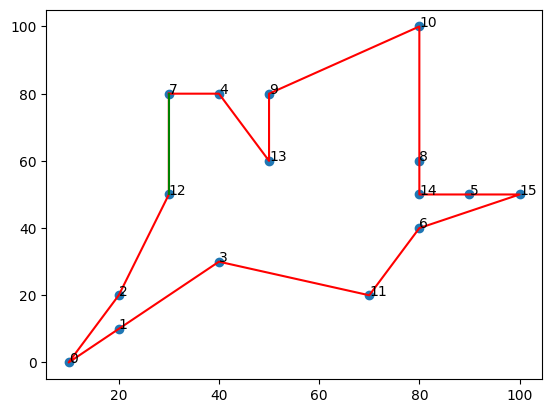

In [178]:
print(hof[0])
print(distance_travelled(hof[0]))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(data_points['x'], data_points['y'])
plt.plot(hof_city['x'], hof_city['y'], 'r')
for index, (x,y) in enumerate(data_points.values):
    ax.annotate(str(index), xy=(x,y))
plt.plot(hof_city['x'][-2:], hof_city['y'][-2:], 'g')